In [1]:
# Import libraries required for EDA
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os
import warnings
import time

# Import Scikit-learn required libraries
from sklearn.neighbors import KernelDensity

# Import file system libraries
from pathlib import Path

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
 

# Set pandas DataFrame visualization parameters
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


In [2]:
import sys
sys.path.append("..")

from library.irplib import main, irpplots

## 2. - Datasets creation

### 2.2. - Kelvin's dataset feature distribution

In [3]:
# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first n rows of dataframe
# df.head(10)

# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(6)


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,-13288.0,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,440,439,98.8,1.340,0.4020,0.013906,0.007339,0.000068,6996.920446,0.003996,97.806426,0.417865,0.406002,0.246911,-0.465256,-0.983144,-0.243006,-0.999749,-0.430895,-0.405723,0.479990,0.223469,0.118674,0.543475,-0.143542,-0.224060,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.626646,0.003144,74.045736,-0.815980,0.485794,-0.004081,0.816347,-0.999998,0.005077,-0.727257,0.196662,-0.818575,-0.197284,0.261753,0.195657,0.721794,-0.195947,-0.677041,1.0,2.0,646.745868,590.821024,650.519613,606.459678,-73.570409,-23.618769,0.029079,469.178802,7.827098e+03,4.374142e+16,3.392176,260.727425,16.110807,54063.675421,1.958295,46.594699,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0
8,1,3.570013,5,-9.248105,-7.327533,7.425994,26899.0,3434.0,-82.0,-26067.0,6638.2,56.8,-847.8,-3328.2,1.0,0.0,4.04,4.04,430,429,99.0,1.402,0.4030,0.015178,0.003417,0.000031,7001.561205,0.001028,97.767002,0.025433,0.318842,0.027919,-0.050648,-0.997384,-0.040625,-0.999560,-0.053437,-0.319966,0.079098,0.016432,-0.049850,0.760496,0.046685,-0.015341,DEBRIS,1.0,0.0,3.54,3.55,33.0,33.0,100.0,1.650,0.0045,0.151857,0.000000,0.008730,6880.588349,0.017491,82.431524,-0.896007,-0.341763,0.075631,0.895993,-1.000000,-0.075170,-0.982560,0.962694,0.243049,-0.962685,-0.389578,0.249596,0.811324,-0.249363,0.344542,1.0,2.0,630.622566,616.225845,622.796659,382.106039,-54.109782,-75.708851,-0.947480,62.058087,5.097272e+06,8.825836e+15,5.455330,99.916400,115.552629,27824.072312,3.780796,97.159318,0.124802,30.242768,0.005883,0.174956,0.003408,0.058311,71.0,87.0,21.0,5.0
28,2,0.401947,2,-30.000000,-7.449283,37296.168207,18708.0,14347.0,-717.9,-5159.0,17968.9,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,481,481,99.1,1.056,3.4479,0.019441,0.014506,0.000013,7158.408492,0.000863,98.523055,0.170637,0.077322,0.044859,-0.301307,-0.945516,-0.007249,-0.999839,-0.187388,-0.076980,0.317338,0.101294,0.042436,-0.524384,-0.042744,-0.102280,UNKNOWN,1.0,0.0,14.56,14.56,18.0,18.0,100.0,1.733,NaN,0.858056,0.474456,0.000591,7168.395415,0.001298,69.718579,-0.733858,0.811887,-0.712991,0.677382,-0.935640,0.552588,-0.999956,0.728830,-0.812411,-0.671514,0.854603,-0.742879,0.966785,0.540052,-0.855151,12.0,2.0,786.448033,774.094951,799.560390,780.956440,63.902737,-16.009902,-0.057504,279.634916,1.440938e+03,1.080252e+12,2.800282,101.046821,9.139996,231.198248,1.510495,117.423294,0.009590,0.219821,0.002918,0.105403,0.002903,0.290009,70.0,77.0,0.0,4.0
49,3,0.283061,19,-30.000000,-8.439735,45859.719269,23861.0,13574.0,51.8,10055.9,21639.4,-39.6,-12310.9,5

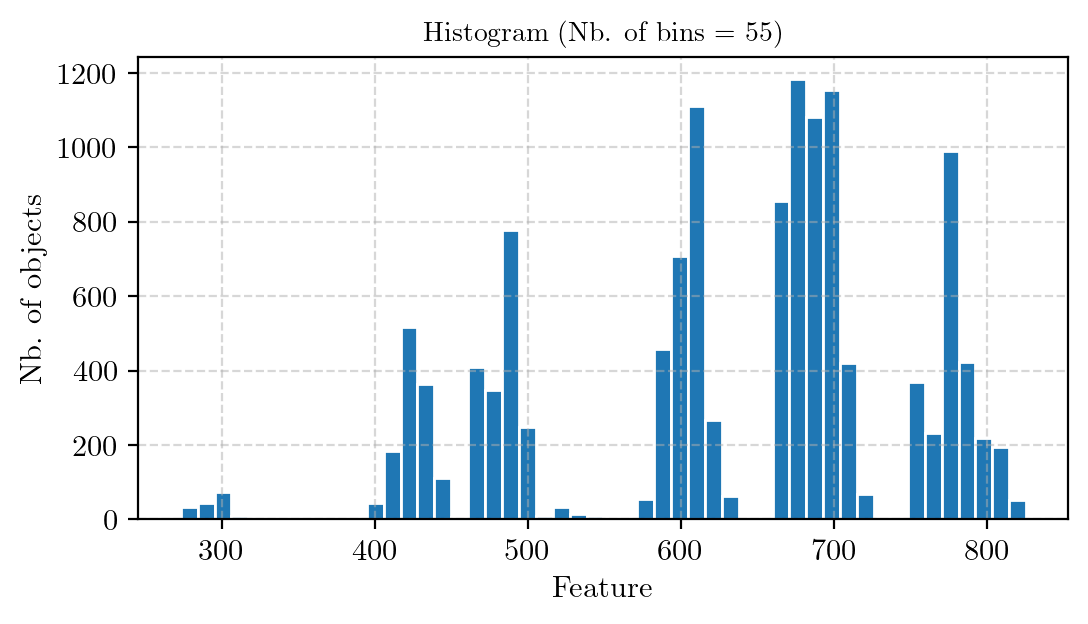

In [5]:
# data = sample
data = df_lastCDM['t_h_per'].to_numpy()

bins = main.nbins(data, 'fd')

plt.figure(figsize=(6,3))
plt.hist(data, bins=50, ec='white')
plt.xlabel('Feature')
plt.ylabel('Nb. of objects')
plt.title('Histogram (Nb. of bins = %d)' % bins['n'], fontsize=10)
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.show()


## 3. - [Kernel Estimator and Bandwidth Selection for Density and its Derivatives](https://cran.microsoft.com/snapshot/2015-07-29/web/packages/kedd/vignettes/kedd.pdf)

### 3.2.1. - Maximum likelihood cross-validation (MLCV)

[Kernel Estimator and Bandwidth Selection for Density and its Derivatives](https://arxiv.org/pdf/2012.06102.pdf)


$MLCV(b_w) = \left( \frac{1}{n}\cdot\sum_{i=1}^{n}\log \left[ \sum_{j\neq i} K\left( \frac{X_j-X_i}{b_w}\right)\right] - \log\left[(n-1)\cdot b_w\right] \right)$

In [ ]:
def mlcv(data, bw, print_log=True):
    """Maximum likelihood cross-validation (MLCV)"""
    
    # Calculate number of data points
    n = len(data)
    
    # Create gaussian kernel function
    kernel = lambda x: 1/(np.sqrt(2*np.pi))*np.exp(-0.5*x**2)

    # Initialize output with the second term of the equation
    output = -np.log((n-1)*bw)
    
    # Iterate over all the values of the data to compute the argument of the first term's logarithm
    for i in range(n):
        
        # Get second dimension of the data
        data_j = [data[j] for j in range(n) if j!=i]
        
        # Compute the argument of the logarithm and add it to the output.
        log_arg = kernel((data_j - data[i])/bw)
        output = output + 1/n*np.log(np.sum(log_arg))
        
    if print_log==True: print('\t - Bandwidth = %.4e \t MLCV = %.4e' % (bw, output))
    
    return output

def argmax_mlcv(data, bwlim, tol=1e-3, max_iter=50, print_log=True):
    """Compute bandwidth that maximizes MLCV"""
    
    # Define initial bandwidths, steps, best bandwidth and number of iterations
    bandwidths, step = np.linspace(bwlim[0], bwlim[1], num=4, endpoint=True, retstep=True)

    best_bw = 0
    max_mlcv = -np.inf
    n_iter = 0
    
    while True and n_iter<max_iter:

        print('\nComputing MLCV for the bandwidths in range: [%.5f, %.5f] (iter = %d)' % 
              (bandwidths[0],bandwidths[-1], n_iter))

        # Compute MLCV for every bandwidth
        mlcv_array = [mlcv(data, bw, (print_log==True or print_log=='full')) for bw in bandwidths]
        
        # Get the maximum local MLCV its corresponding bandwidth bw
        
        print_format = {'mlcv': order_of_magnitude(abs(max_mlcv - max(mlcv_array))),
                       'bw': order_of_magnitude(abs(best_bw - bandwidths[mlcv_array==max(mlcv_array)][0]))}
        # print(print_format)
        
        max_mlcv = max(mlcv_array)
        best_local_bw = bandwidths[mlcv_array==max_mlcv][0]

        # Stop loop if preccision required is met
        precission = abs(best_bw - best_local_bw)
        if print_log!=False:
            print(" -> Best local bandwidth = {:.4e}\n"\
                  "    Max. local MLCV      = {:.4e}\n"\
                  "    Step                 = {:.4e}\n"\
                  "    Precission           = {:.4e}"\
                  .format(best_local_bw, max_mlcv, step, precission))
        
        if precission<=tol: break
            
        # Assign new best local bandwidth and reassign bandwidth limits for another iteration
        best_bw = best_local_bw
            
        # Define new bandwidth array for another iteration
        bwlim = [max(best_bw - step, best_bw*0.5), best_bw + step]
        bandwidths, step = np.linspace(bwlim[0], bwlim[1], num=4, endpoint=True, retstep=True)
            
        n_iter += 1
    
    return best_bw, max_mlcv



In [ ]:
bwlim = [0.1, 2.0]
best_bw, max_mlcv = argmax_mlcv(data, bwlim, tol=1e-3, max_iter=50, print_log=True)

print("Best bandwidth = %.4e / Max. MLCV = %.4e" % (best_bw, max_mlcv))

print_kde(data, best_bw)

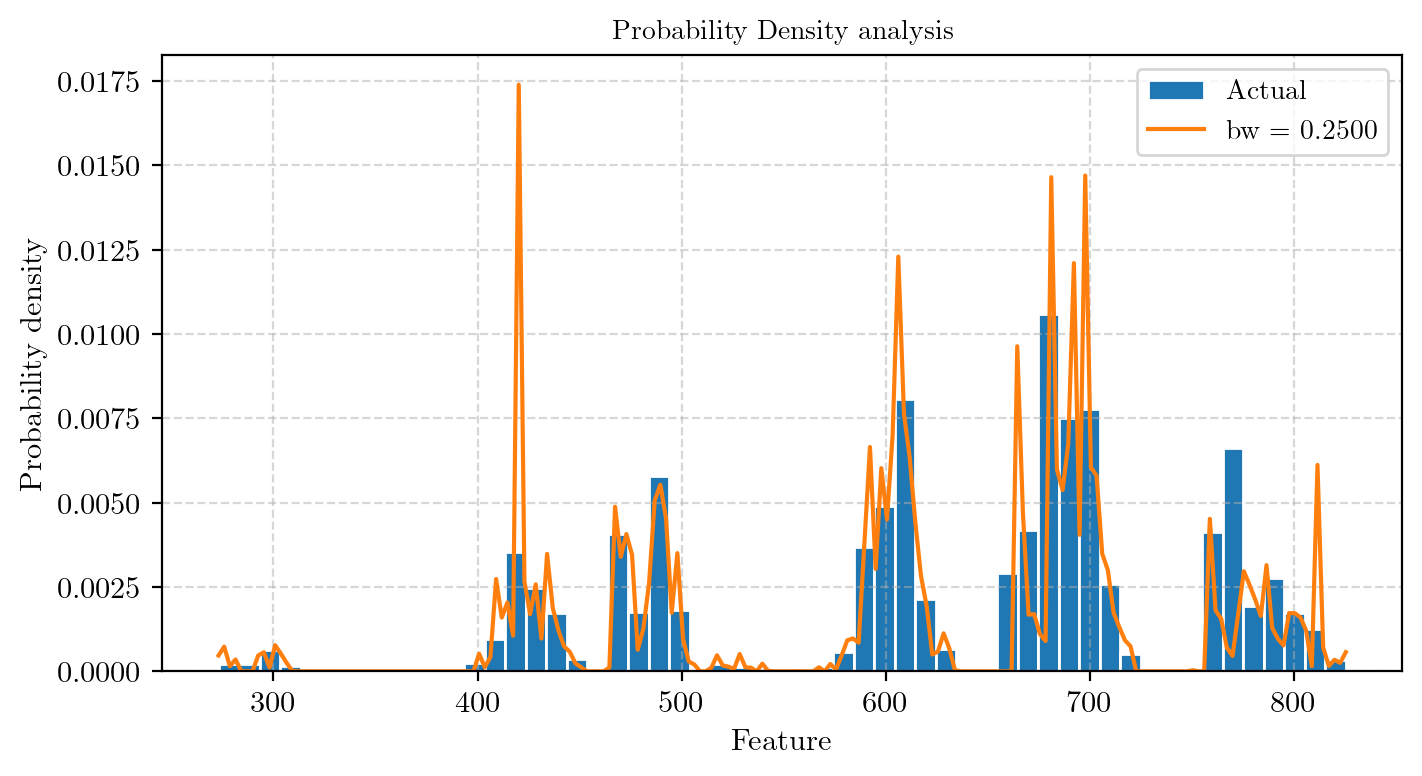

In [6]:
irpplots.plot_kde(data, [0.25], figsize=(8,4))

In [ ]:

import statsmodels
import statsmodels.api as sm

settings = statsmodels.nonparametric.kernel_density.EstimatorSettings(
    efficient=True,
    n_sub=len(data)//10)


dens_u = sm.nonparametric.KDEMultivariate(data=data,
                                          var_type='c', 
                                          bw='cv_ml',
                                         defaults=settings)
dens_u.bw


In [ ]:
print_kde(data, 0.7877071)

### 3.2.2. - Minimum Squared Error cross-validation (MSECV)

In [ ]:
# Define function to compute KDE
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(np.array(x).reshape(-1,1))
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    return np.exp(log_pdf)

In [ ]:
def plot_mse_bw(bandwidths, mse):
    
    # Plot MSE vs bandwidth
    plt.figure(figsize=(6,3))
    plt.plot(bandwidths, mse, '--')
    plt.plot(bandwidths[mse==mse.min()][0], mse.min(), 'ro', label = f'BW = {best_bw:.4f}')
    plt.xlabel('Bandwidth', fontsize=10)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
    plt.title('Bandwidth selection using MSE cross-validation', fontsize=12)
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    return

In [ ]:
# Features to approximate t_h_per, t_j2k_sma, t_j2k_inc, t_j2k_ecc
features = ['t_h_per', 't_j2k_sma', 't_j2k_inc', 't_j2k_ecc', 'azimuth']
feature = features[4]
data = df_lastCDM[feature].to_numpy()

# Shuffle data
np.random.shuffle(data)

sample_sizes  = np.arange(500,5000,500)

tol = 1e-5
max_iter = 100
bins = nbins(data, 'fd')

# Create cluster array to get batches of data
n_samples = np.arange(start=2, stop=11, step=1, dtype=np.int32)
best_bws = np.zeros(len(n_samples))

for i, n_clusters in enumerate(n_samples):
    print(f'Total batches = {n_clusters} ({len(data)//n_clusters} data points per batch)')
    
    clusters = np.random.randint(low=0, high=n_clusters, size=len(data))
    
    # Initialize array to store actual probabilty densities (apds)
    apds = np.zeros((bins['n'], n_clusters))
    
    for j in range(n_clusters):
        sample = data[clusters==j]

        apd, bin_edges = np.histogram(sample, bins = bins['n'], density=True)
        apds[:,j] = apd

    # Compute bin centers to which the density computed shall be linked
    bin_centers = bin_edges[:-1] + bins['width']/2

    # Compute average of all actual probability densities computed
    avg_apd = np.mean(apds, axis=1, dtype=np.float64)

    # Initialize bandwidth and MSE arrays
    bandwidths, step = np.linspace(bins['width']/100, bins['width'], 100, retstep=True)

    best_bw = np.inf
    while True:

        mse = np.zeros(len(bandwidths))

        for b, bandwidth in enumerate(bandwidths):

            epd = kde_sklearn(data, bin_centers, kernel='gaussian', bandwidth=bandwidth)
            mse[b] = ((epd - avg_apd)**2).mean()

        
        bw = bandwidths[mse==mse.min()][0]

        # print(f'  New bandwidth: {bw:.4e} MSE: {mse.min():.5e}')
        if abs(1 - best_bw/bw) <= tol: break 

        bandwidths, step = np.linspace(bw-step, bw+step, 100, retstep = True)
        best_bw = bw

    best_bws[i] = best_bw 

    print(f'Best bandwidth = {best_bw:.5f} \nMSE = {mse.min():.4e}\n')

scale = 10**order_of_magnitude(best_bws.mean())
best_bw = (math.ceil(best_bws.mean()/scale)*scale)

print(f'Final Optimal bandwidth = {best_bw}')


In [ ]:
# Scale best_bw to 1.75

kde_x_grid = np.linspace(bin_centers[0], bin_centers[-1],1000)
epd = kde_sklearn(data, kde_x_grid, kernel='gaussian', bandwidth=best_bw)

plt.figure(figsize=(8,4))
plt.plot(bin_centers, avg_apd, label = r'Actuals average')
plt.plot(kde_x_grid, epd, label = r'Estimated')
plt.xlabel('Feature')
plt.ylabel('Probability density')
plt.title('Probability density (Nb. bins = %d)' % bins['n'], fontsize=10)
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.legend(loc='best', fontsize=10)
plt.show()

print_kde(data, [best_bw], figsize=(8,4))